# CelebA Image Generation with Variational Autoencoders

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as du
from torch.utils.data import Dataset
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import cv2 
import numpy as np
from tqdm import tqdm
import math
import torchvision.utils as vutils

## Downloading CelebA Dataset

In [2]:
# link to dataset: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
transform = transforms.Compose([
                                transforms.Resize((64, 64)),
                               transforms.CenterCrop((64,64)),
                               transforms.ToTensor(),
                               transforms.Normalize([0.506, 0.425, 0.383], [0.304, 0.284, 0.283]),
                            ])
train_data = datasets.ImageFolder("./datasets/celeba", transform=transform)

## Ploting 16 images from Dataset

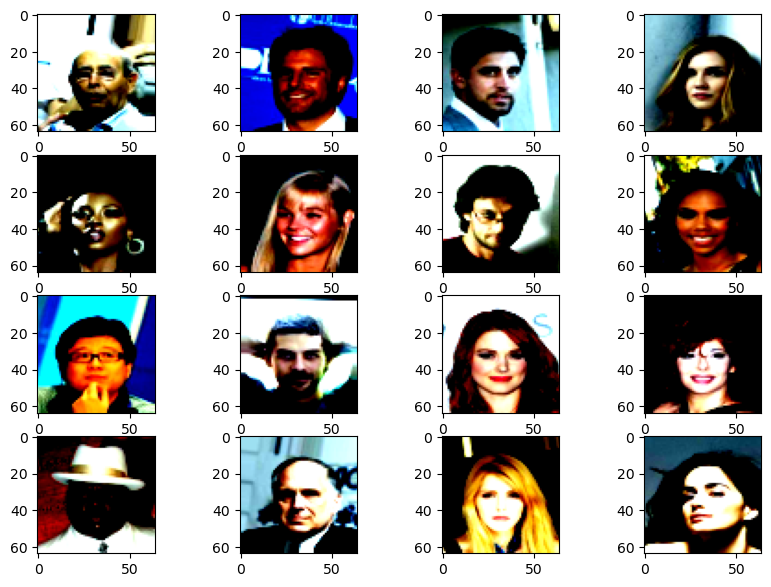

In [9]:
fig = plt.figure(figsize=(10, 7))
load_img = du.DataLoader(dataset=train_data,
                             batch_size=1,
                             shuffle=True)
for i, (img,_) in enumerate(load_img):
    if(i >= 16):
        break
    fig.add_subplot(4, 4, i+1)
    img = torch.einsum("cwh->whc", img[0])
    img[img<0] = 0
    img[img>1] = 1
    plt.imshow(img)

In [4]:
class VAE(nn.Module):
    def __init__(self, in_channels, latent_dim):
        '''
        in_channels: number of channels in image
        latent_dim: size of latent dimension
        references: 
        https://www.youtube.com/watch?v=VELQT1-hILo&list=RDCMUCkzW5JSFwvKRjXABI-UTAkQ&start_radio=1&rv=VELQT1-hILo&t=2104
        https://github.com/AntixK/PyTorch-VAE/blob/master/models/vanilla_vae.py
        https://www.tensorflow.org/tutorials/generative/cvae
        model in tf paper was not large enough to generate good images for
        the CelebA dataset, so I increased the size of the encoder and decoder 
        '''
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
                        nn.Conv2d(in_channels, 32, kernel_size=3, stride=(2, 2)),
                        nn.BatchNorm2d(32),
                        nn.LeakyReLU(),
                        nn.Conv2d(32, 64, kernel_size=3, stride=(2, 2)),
                        nn.BatchNorm2d(64),
                        nn.LeakyReLU(),
                        nn.Conv2d(64, 128, kernel_size=3, stride=(2, 2)),
                        nn.BatchNorm2d(128),
                        nn.LeakyReLU(),
                        nn.Conv2d(128, 256, kernel_size=3, stride=(2, 2)),
                        nn.BatchNorm2d(256),
                        nn.LeakyReLU(),
                        nn.Conv2d(256, 512, kernel_size=3, stride=(2, 2)),
                        nn.BatchNorm2d(512),
                        nn.LeakyReLU(),
                        nn.Flatten(),
        )
        self.mean = nn.Linear(512, latent_dim)
        self.logvar = nn.Linear(512, latent_dim)

        self.decoder_project = nn.Linear(latent_dim, 512*4*4)
        self.decoder = nn.Sequential(
                        nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
                        nn.BatchNorm2d(256),
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
                        nn.BatchNorm2d(128),
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
                        nn.BatchNorm2d(64),
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
                        nn.BatchNorm2d(32),
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(32, in_channels, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(in_channels),
                        nn.Sigmoid()
        )
        self.latent_dim = latent_dim
        
    def encode(self, x):
        x = self.encoder(x)
        mean = self.mean(x)
        logvar = self.logvar(x)
        return mean, logvar
    
    def decode(self, x):
        x = self.decoder_project(x)
        x = torch.reshape(x, (-1, 512, 4, 4))
        x = self.decoder(x)
        return x

    def reparameterize(self, mean, logvar):
        '''
        reparameterization trick
        '''
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mean
    
    def sample(self, z):
        '''
        Generates images from z 
        z: tensor in latent space, with the shape of (batch x latent_dim) 
        '''
        samples = self.decode(z)
        return samples
    
    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        z_new = self.decode(z)
        return self.decode(z), mean, logvar

In [5]:
def loss_function(model, data):
    recon_data, mean, logvar = model(data)
    recon_loss = F.binary_cross_entropy(recon_data, data, reduction="sum")
    kl_div = -torch.sum(1 + torch.log(logvar.pow(2)) - mean.pow(2) - logvar.pow(2))
    loss = recon_loss + kl_div
    return loss

In [6]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"using device: {device}")
batch_size = 32
learning_rate = 1e-4
epochs = 5
in_channels = 3
latent_dim = 128
upscale_channels = 64
features = 64
torch.manual_seed(0)

model = VAE(in_channels, latent_dim)

optimizer = optim.Adam(model.parameters(), lr = learning_rate)

# load training data in batches
train_loader = du.DataLoader(dataset=train_data,
                             batch_size=batch_size,
                             shuffle=True)
# send model over to device
model.to(device)
model.train()

using device: cuda:0


VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_slope=0.01)
    (15): Flatten(

100%|██████████| 6332/6332 [20:11<00:00,  5.23it/s]


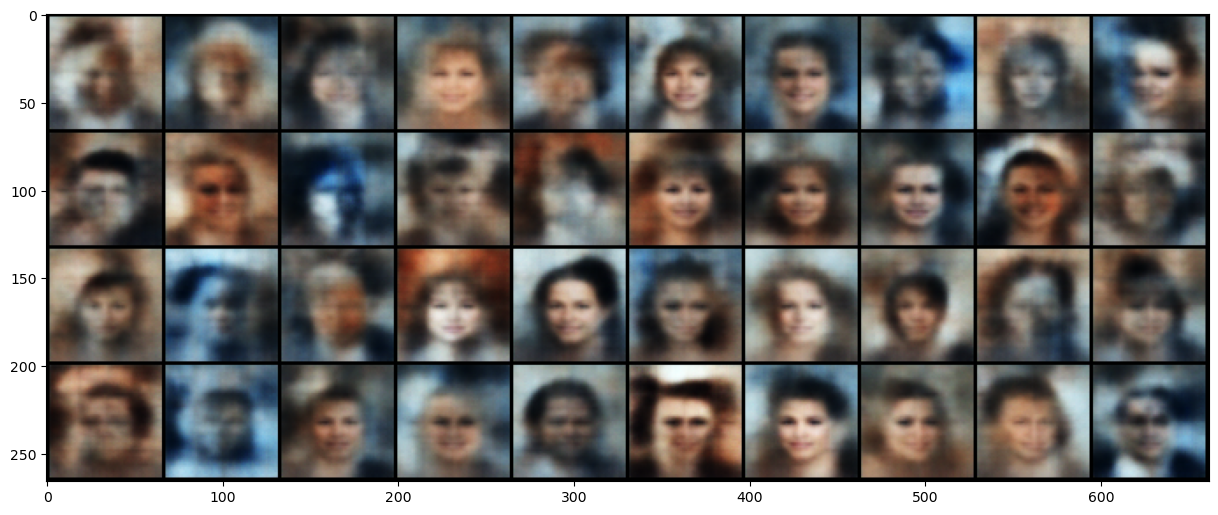

Epoch: 1, Training Loss: -4345.108885877629


100%|██████████| 6332/6332 [16:54<00:00,  6.24it/s] 


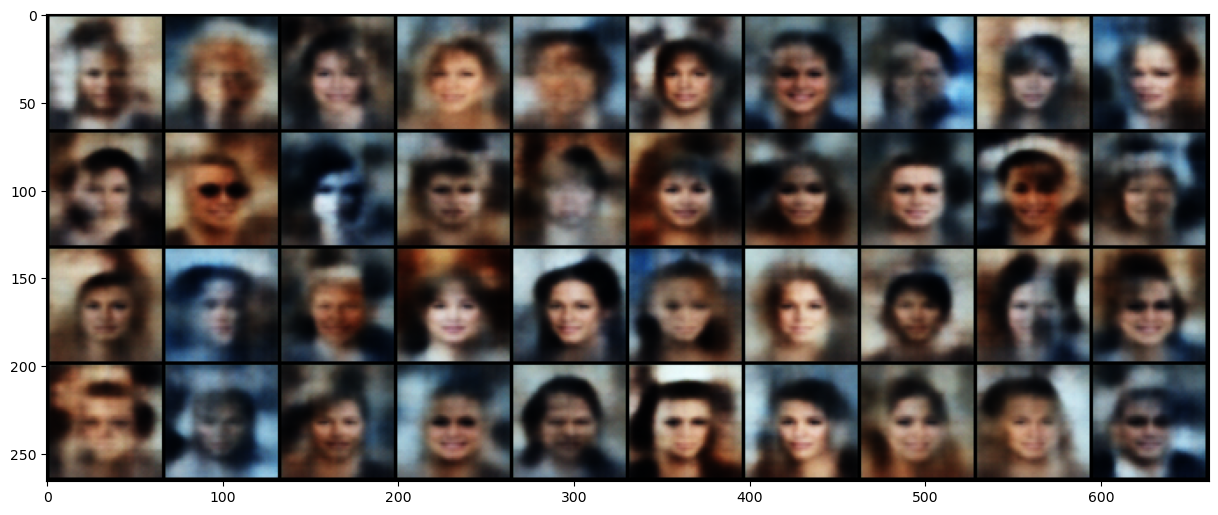

Epoch: 2, Training Loss: -12965.607216294564


100%|██████████| 6332/6332 [16:29<00:00,  6.40it/s]


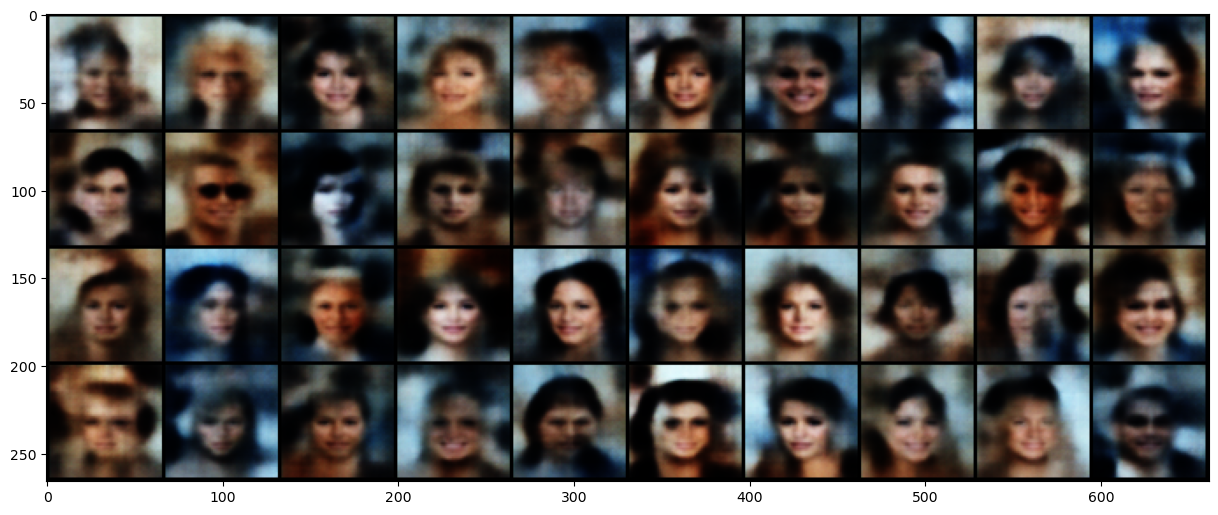

Epoch: 3, Training Loss: -20595.986818712703


100%|██████████| 6332/6332 [09:04<00:00, 11.63it/s] 


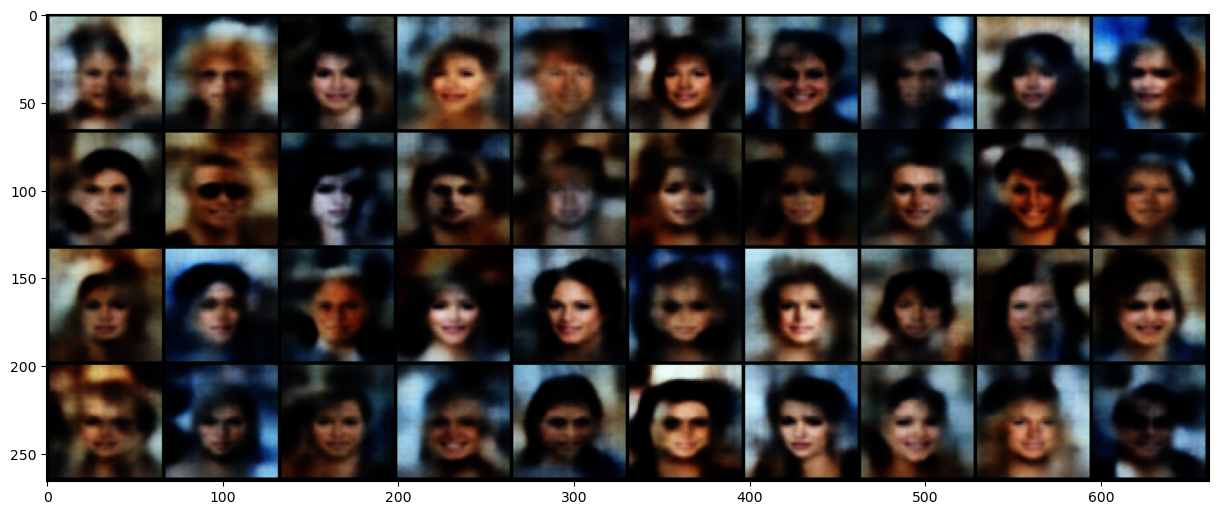

Epoch: 4, Training Loss: -27950.84863638425


100%|██████████| 6332/6332 [08:00<00:00, 13.17it/s]


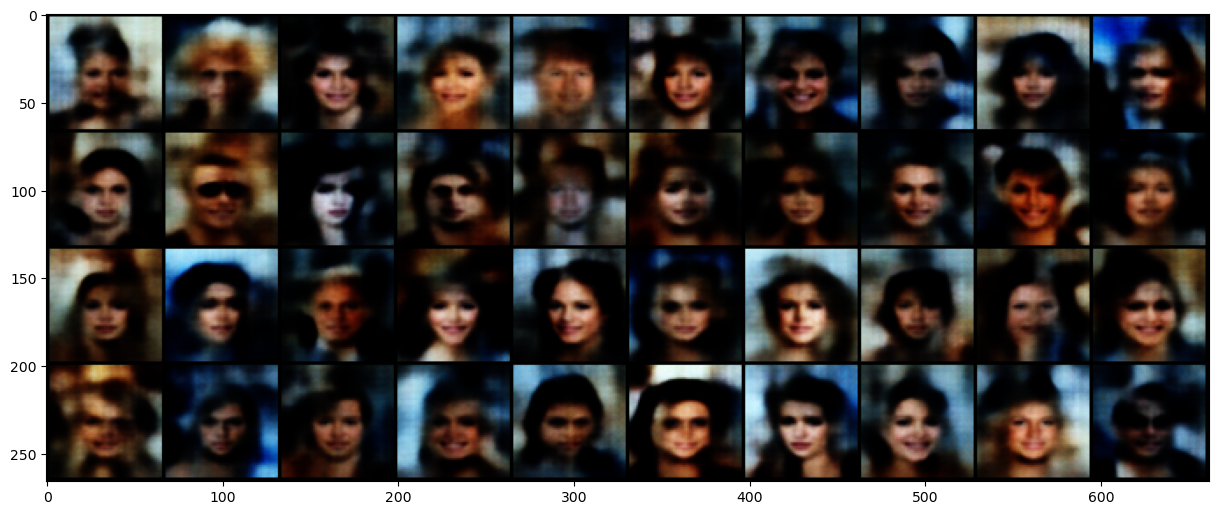

Epoch: 5, Training Loss: -35195.883611299294


In [7]:
height = 4
width = 10
validation_latent_space = torch.randn(height*width, latent_dim, device=device)

# iterating through all epochs
for epoch in range(1, epochs+ 1):    
    # training step
    train_loss = 0.
    model.train()

    # iterating through entire dataset in batches
    for batch_idx, (data, _) in enumerate(tqdm(train_loader)):
        # sending batch over to device
        data = data.to(device)
        # zeroing out previous gradients
        optimizer.zero_grad()
        loss = loss_function(model, data)
        
        train_loss += loss.item()
        loss.backward()
        optimizer.step()


    '''
    first row is initial input image, 
    second row is the decoded image from input image, 
    third row is a randomly sampled noise
    '''
    with torch.no_grad():
        model.eval()
        synth_img = vutils.make_grid(model.sample(validation_latent_space), nrow=width, hcol=height, padding=2, normalize=True).detach().cpu()
        fig = plt.figure(figsize=(15,15))
        plt.imshow(torch.einsum("cwh->whc", synth_img))
    plt.show()
        
    train_loss /= len(train_loader.dataset)

    # printing loss per epoch
    print(f"Epoch: {epoch}, Training Loss: {train_loss}")

## Testing Model on New Noise

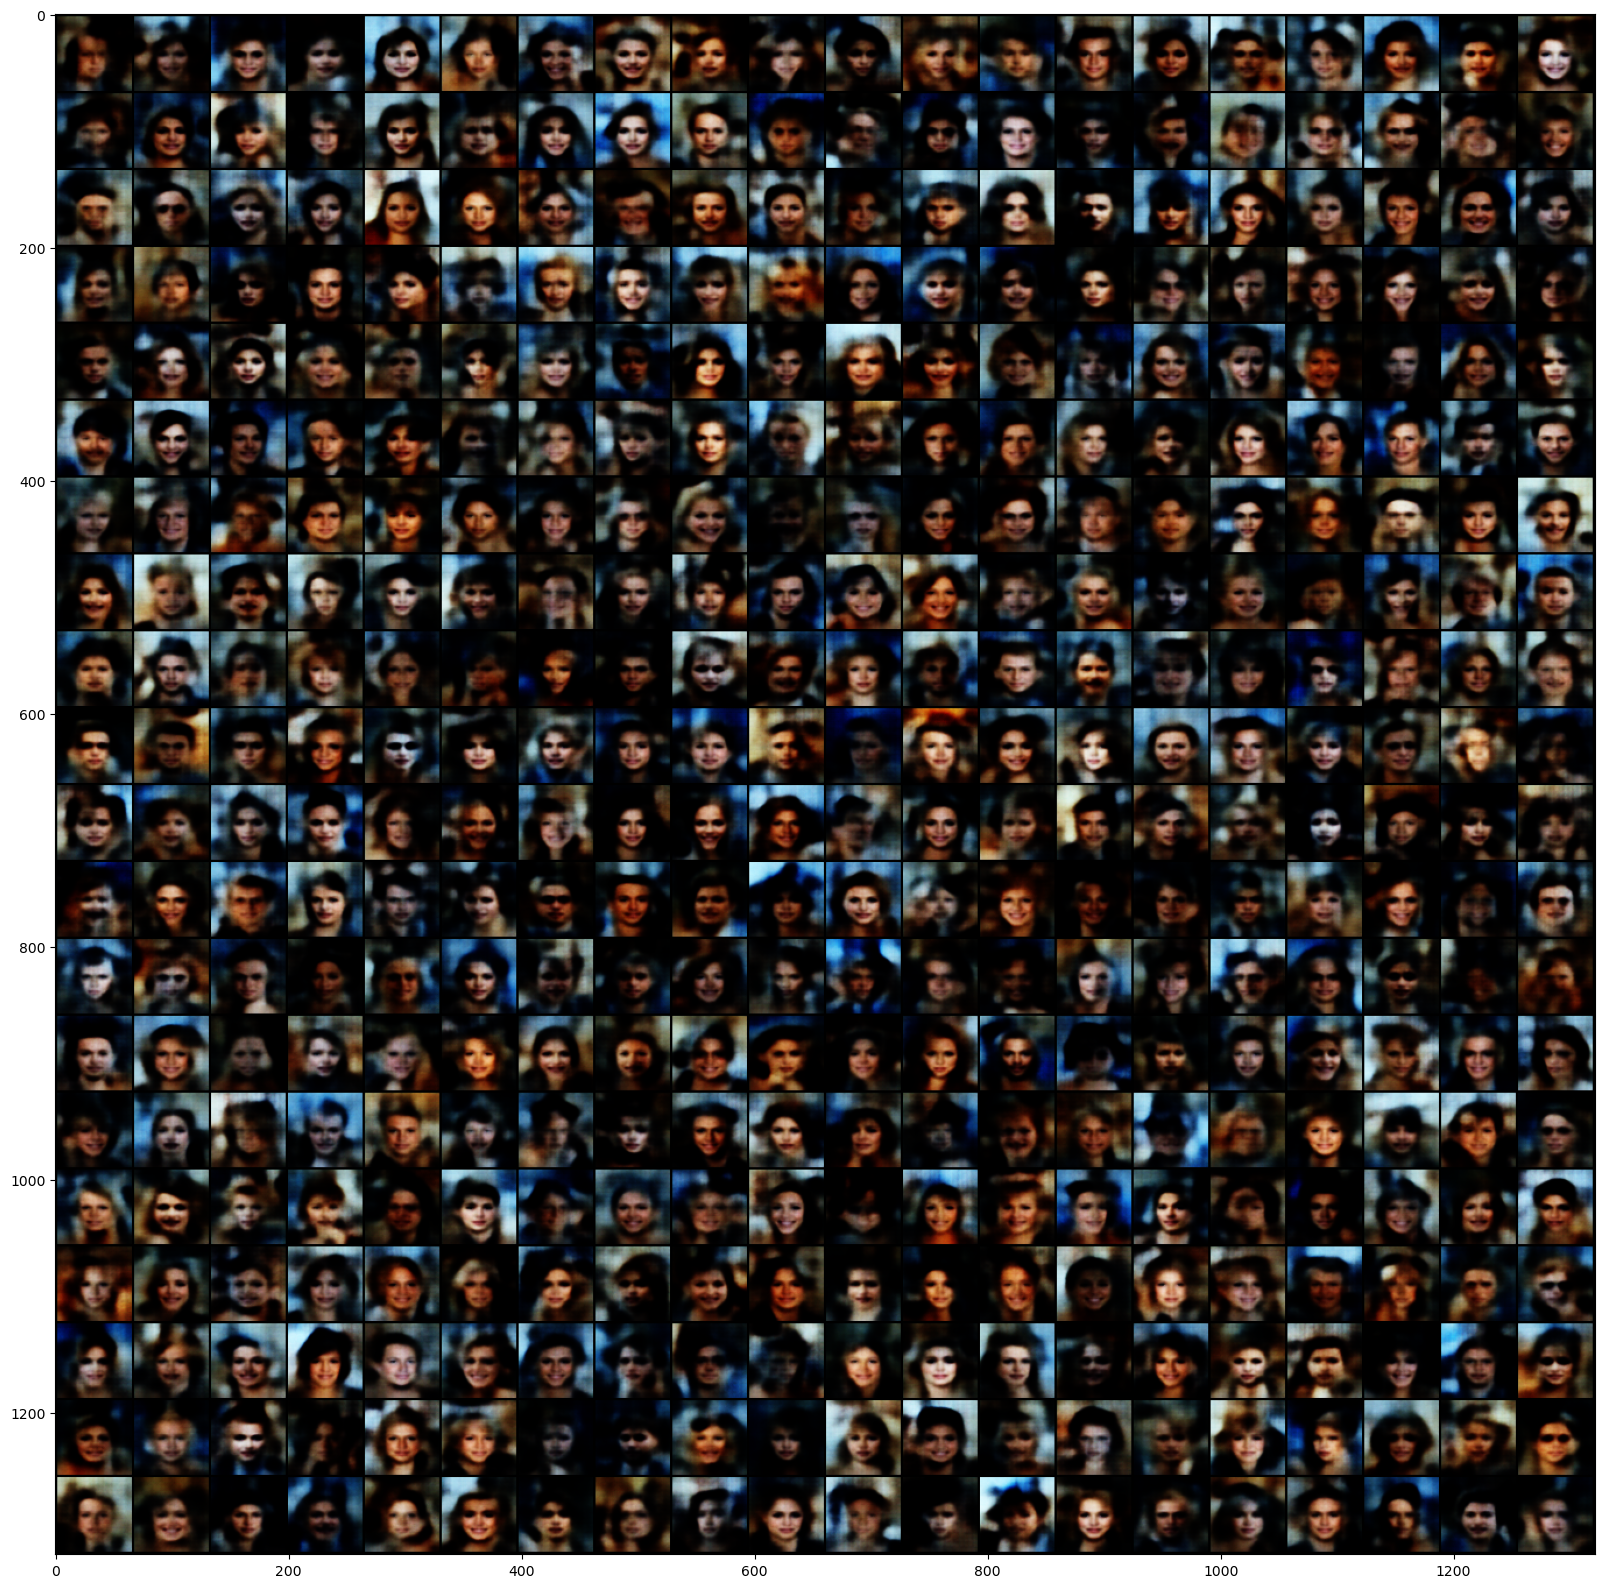

In [8]:
height = 20 
width = 20
test_latent_space = torch.randn(height*width, latent_dim, device=device)
synth_img = vutils.make_grid(model.sample(test_latent_space), nrow=width, hcol=height, padding=2, normalize=True).detach().cpu()
fig = plt.figure(figsize=(20,20))
plt.imshow(torch.einsum("cwh->whc", synth_img))